<a href="https://colab.research.google.com/github/sysadminamit/HelpfulnessPrediction-of-Online-Review/blob/master/Word2VecCustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
df=pd.read_csv('gdrive/My Drive/AmazonElectronicsProductReviewClean.csv')
df.head()

,Unnamed: 0,overall,Helpfulfactor,review,Summary
0,0,1,1.0,excite especially since every time refuse turn...,very disappointed
1,1,3,1.0,enter multiple stop vias nowhere near userfrie...,1st impression
2,2,2,1.0,might think conjested city situation might get...,great grafics poor gps
3,3,5,1.0,hd picture samsung tv excellent,hdmi nook adapter cable
4,4,5,1.0,warn,this works great but read the details


In [3]:
df = df.sample(n = 50000)
df.head(1)

,Unnamed: 0,overall,Helpfulfactor,review,Summary
14285,14289,3,1.0,cable work design,works as designed


In [4]:
df['Helpfulfactor'].value_counts()

1.0    33612
0.0    16388
Name: Helpfulfactor, dtype: int64

In [5]:
from sklearn.utils import resample
data_majority = df[df.Helpfulfactor == 1.0 ]
data_minority = df[df.Helpfulfactor == 0.0 ]
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=33376,    # to match majority class
                                 random_state=123) # reproducible results
df = pd.concat([data_majority, data_minority_upsampled])
df['Helpfulfactor'].value_counts()

1.0    33612
0.0    33376
Name: Helpfulfactor, dtype: int64

In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66868 entries, 0 to 66867
Data columns (total 5 columns):
Unnamed: 0       66868 non-null int64
overall          66868 non-null int64
Helpfulfactor    66868 non-null float64
review           66868 non-null object
Summary          66868 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.6+ MB


In [0]:
x = df.review
y = df.Helpfulfactor

In [0]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [9]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print( "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print( "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 53494 entries with 49.84% negative, 50.16% positive
Validation set has total 6687 entries with 49.51% negative, 50.49% positive
Test set has total 6687 entries with 50.13% negative, 49.87% positive


In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [0]:
def labelize_review_ug(review,label):
    result = []
    prefix = label
    for i, t in zip(review.index, review):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [0]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_review_ug(all_x, 'all')

In [13]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 66868/66868 [00:00<00:00, 1876331.96it/s]


In [14]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 66868/66868 [00:00<00:00, 2108693.87it/s]


CPU times: user 36.9 s, sys: 259 ms, total: 37.2 s
Wall time: 20.9 s


In [15]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 66868/66868 [00:00<00:00, 1939026.84it/s]


In [16]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 66868/66868 [00:00<00:00, 1941550.39it/s]


CPU times: user 1min 1s, sys: 222 ms, total: 1min 1s
Wall time: 33 s


In [17]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [18]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [19]:
len(model_ug_cbow.wv.vocab.keys())

10553

In [20]:
len(model_ug_sg.wv.vocab.keys())

10553

In [21]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 10553 word vectors.


In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

Using TensorFlow backend.


In [23]:
x_train_seq = pad_sequences(sequences, maxlen=100)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (53494, 100)


In [0]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=100)

In [0]:
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv1D,Conv2D,GlobalMaxPooling1D,BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [33]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.optimizers import Adam
tweet_input = Input(shape=(100,), dtype='int32')

tweet_encoder = Embedding(10000, 200, weights=[embedding_matrix], input_length=100, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=400, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=400, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=400, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(10, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.00001),
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 200)     2000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 99, 400)      160400      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 98, 400)      240400      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (

In [34]:
history = model.fit(x_train_seq, y_train, batch_size=64, epochs=80,validation_data=(x_val_seq, y_validation), verbose=1)

Train on 53494 samples, validate on 6687 samples
Epoch 1/80
53494/53494 [==============================] - 14s 268us/step - loss: 0.6995 - acc: 0.5052 - val_loss: 0.6924 - val_acc: 0.5122
Epoch 2/80
53494/53494 [==============================] - 14s 257us/step - loss: 0.6906 - acc: 0.5199 - val_loss: 0.6898 - val_acc: 0.5195
Epoch 3/80
53494/53494 [==============================] - 14s 260us/step - loss: 0.6858 - acc: 0.5323 - val_loss: 0.6872 - val_acc: 0.5331
Epoch 4/80
53494/53494 [==============================] - 14s 257us/step - loss: 0.6799 - acc: 0.5487 - val_loss: 0.6836 - val_acc: 0.5496
Epoch 5/80
53494/53494 [==============================] - 14s 253us/step - loss: 0.6729 - acc: 0.5681 - val_loss: 0.6800 - val_acc: 0.5629
Epoch 6/80
53494/53494 [==============================] - 13s 250us/step - loss: 0.6663 - acc: 0.5860 - val_loss: 0.6765 - val_acc: 0.5790
Epoch 7/80
53494/53494 [==============================] - 13s 252us/step - loss: 0.6588 - acc: 0.6030 - val_loss: 0.6

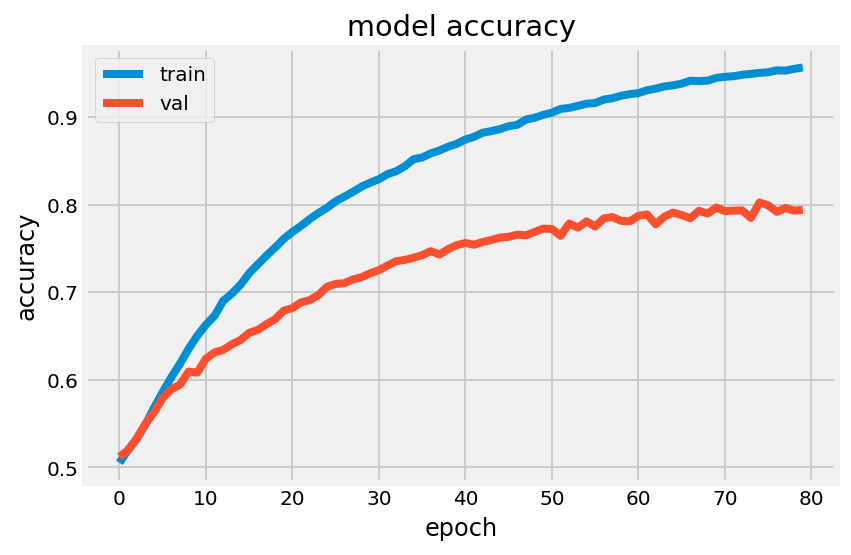

In [35]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

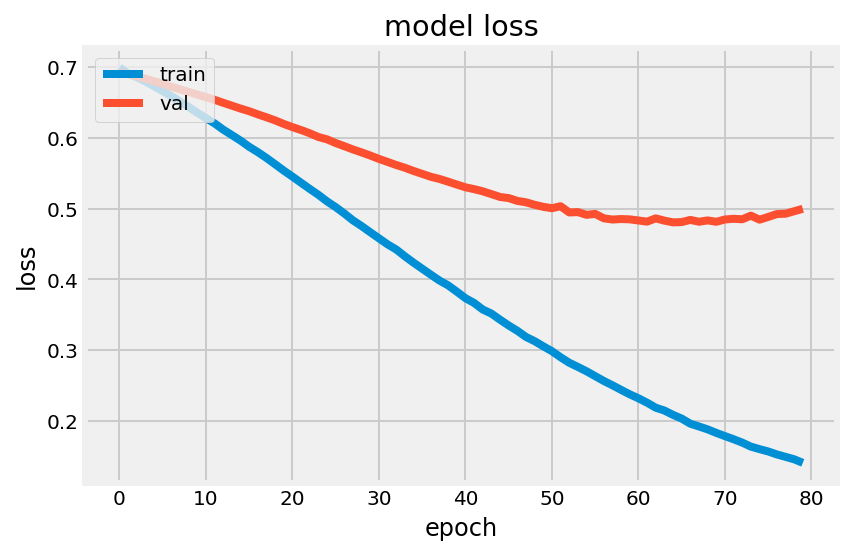

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [37]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Word2vecModel80Epoch.hdf5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Word2vecModel80Epoch.hdf5 


In [0]:
from google.colab import auth
auth.authenticate_user()

In [39]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

W0724 16:44:24.260180 139992290359168 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [40]:
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'Word2vecModel80Epoch.hdf5',
  'mimeType': 'text/plain'
}
media = MediaFileUpload('/content/saved_models/Word2vecModel80Epoch.hdf5', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1cBF_jWe9f0kuMtC6sS6wU394-TG8RHAR


In [44]:
from keras.models import load_model

model = load_model(model_path)
model.evaluate(x=x_val_seq, y=y_validation)

6687/6687 [==============================] - 1s 126us/step


[0.49974147635617205, 0.794227605837957]

In [0]:
yhat_cnn = model.predict(x_val_seq)

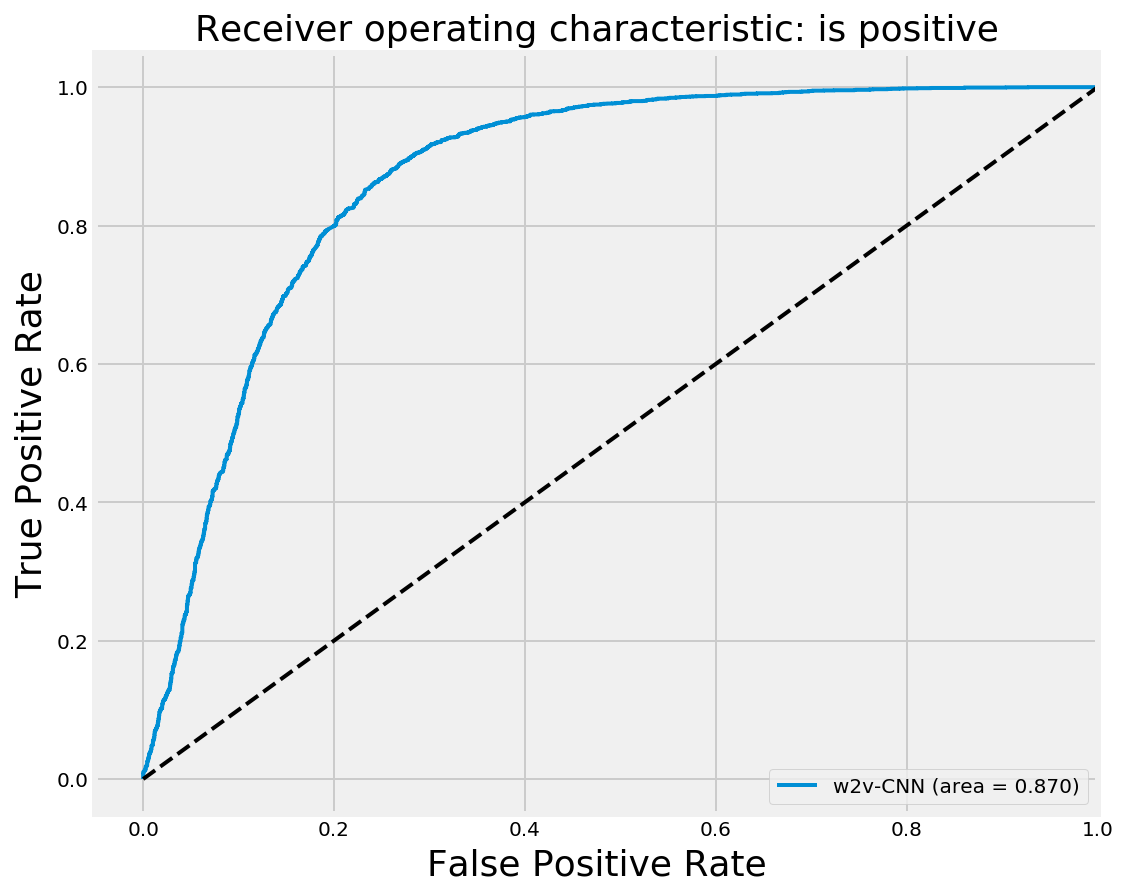

In [54]:
from sklearn.metrics import roc_curve, auc

fpr_cnn, tpr_cnn, threshold = roc_curve(y_validation, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
#plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()
